# VPN detection using NetTiSA flows

In [1]:
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import lightgbm as lgb
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss


In [2]:
df = pd.read_csv("../final_datasets/vpn_iscx_binary.csv")

In [3]:
df

,Unnamed: 0,SRC_PORT,DST_PORT,TIME_FIRST,TIME_LAST,LABEL,PACKETS,PACKETS_REV,BYTES,BYTES_REV,...,ROOT_MEAN_SQUARE,KURTOSIS,TIME_DISTRIBUTION,MEAN_RELATIVE_TIME,DURATION,MEAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,SWITCHING_METRIC,DIRECTIONS
0,0,54269,443,1.433357e+09,1.433357e+09,True,1,0,0,0,...,60.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,1.000000
1,1,443,54269,1.433357e+09,1.433357e+09,True,1,0,1,0,...,61.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,1.000000
2,2,40011,56909,1.433357e+09,1.433357e+09,True,3,0,2,0,...,60.673992,5.333333,0.340934,7.299830,21.411289,10.705644,0.488201,20.923088,1.000000,1.000000
3,3,56909,40011,1.433357e+09,1.433357e+09,True,3,0,4,0,...,61.340579,1.000000,0.336774,7.119728,21.140954,10.570477,0.218230,20.922724,1.000000,1.000000
4,4,443,54269,1.433357e+09,1.433357e+09,True,1,0,149,0,...,209.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243874,243874,9159,443,1.429121e+09,1.429121e+09,False,8,0,645,0,...,197.445246,2.737815,0.507273,0.062890,0.123976,0.017711,0.000057,0.026743,1.428571,1.000000
243875,243875,52293,443,1.429121e+09,1.429121e+09,False,26,45,2920,56153,...,1090.631301,1.160920,0.045983,0.722742,15.717525,0.224536,0.000002,15.529519,0.771429,0.366197
243876,243876,443,9159,1.429121e+09,1.429121e+09,False,10,0,4296,0,...,758.127694,1.437167,0.347169,0.056715,0.163364,0.018152,0.000018,0.090638,1.555556,1.000000
243877,243877,9161,443,1.429121e+09,1.429121e+09,False,31,0,948,0,...,131.815854,17.542362,0.718216,0.249561,0.347474,0.011582,0.000056,0.100971,0.533333,1.000000


In [12]:
default_faetures = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
]

features = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
    "MEAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "KURTOSIS",
    "TIME_DISTRIBUTION",
    "MEAN_RELATIVE_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
]

In [13]:
import sklearn
pd.set_option('display.max_columns', None)

df = df[["LABEL"] + features].copy()

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes


for F in features:
    df.replace([np.inf], 0, inplace=True)
    df.replace([-np.inf], 0, inplace=True)
    df.loc[df[F].isnull(), F] = 0

In [14]:
df

,LABEL,PACKETS,PACKETS_REV,BYTES,BYTES_REV,MEAN,STDEV,VAR,BURSTINESS,MIN,MAX,MIN_MINUS_MAX,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,KURTOSIS,TIME_DISTRIBUTION,MEAN_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,SWITCHING_METRIC,DIRECTIONS,LABEL_code
0,True,1,0,0,0,60,60.000000,0,0.000000,60,60,0,100.000000,0,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1
1,True,1,0,1,0,61,61.000000,0,0.000000,61,61,0,100.000000,0,0.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1
2,True,3,0,2,0,60,1.000000,2,-0.967213,60,62,2,1.666667,0,0.000000,60.673992,5.333333,0.340934,7.299830,21.411289,10.705644,0.488201,20.923088,1.000000,1.000000,1
3,True,3,0,4,0,61,1.000000,1,-0.967742,60,62,2,1.639344,1,1.639344,61.340579,1.000000,0.336774,7.119728,21.140954,10.570477,0.218230,20.922724,1.000000,1.000000,1
4,True,1,0,149,0,209,209.000000,0,0.000000,209,209,0,100.000000,0,0.000000,209.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243874,False,8,0,645,0,140,148.165448,21953,0.028336,60,456,396,105.832463,113,80.714286,197.445246,2.737815,0.507273,0.062890,0.123976,0.017711,0.000057,0.026743,1.428571,1.000000,0
243875,False,26,45,2920,56153,892,631.991297,399413,-0.170610,92,1410,1318,70.851042,612,68.609865,1090.631301,1.160920,0.045983,0.722742,15.717525,0.224536,0.000002,15.529519,0.771429,0.366197,0
243876,False,10,0,4296,0,489,610.145065,372277,0.110218,60,1410,1350,124.774042,524,107.157464,758.127694,1.437167,0.347169,0.056715,0.163364,0.018152,0.000018,0.090638,1.555556,1.000000,0
243877,False,31,0,948,0,90,97.344748,9476,0.039204,60,558,498,108.160831,50,55.555556,131.815854,17.542362,0.718216,0.249561,0.347474,0.011582,0.000056,0.100971,0.533333,1.000000,0


In [15]:
print(f"vpn: {len(df[df['LABEL'] == True])}\tclear: {len(df[df['LABEL'] == False])}")

vpn: 23078	clear: 220801


In [16]:
df = df[["LABEL_code"] + features].copy()

In [17]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [18]:
df.shape

(243879, 25)

In [19]:
print(f"vpn: {len(df[df['LABEL_code'] == 1])}\tclear: {len(df[df['LABEL_code'] == 0])}")

vpn: 23078	clear: 220801


In [20]:
df_validation = df.sample(n = 50000)
df_features =  df[~df.isin(df_validation)].dropna()

In [21]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

In [22]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['LABEL_code']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), 
                        gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']), 
                        # subsample=int(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric=["auc","error","logloss"],
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred)
        if verbose is True:
            print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 5, 60, 5),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 50, 400, 50),
        # 'subsample': hp.quniform('subsample', 3, 20, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [23]:
best_hyperparams = tunne_together_XGBoost_classification(df_features, features, verbose=False)

100%|██████████| 100/100 [09:08<00:00,  5.48s/trial, best loss: -0.8995459704880817]
The best hyperparameters are :  

{'colsample_bytree': 0.792913531949936, 'gamma': 1.0081826342341296, 'max_depth': 15.0, 'min_child_weight': 1.0, 'n_estimators': 200.0, 'reg_alpha': 1.0, 'reg_lambda': 0.005950962442299423}


In [24]:
def XGBoost_classification_tunned(best_hyperparams):
      X=df_features[features]  # Features
      y=df_features['LABEL_code']  # Labels
      #Split on train and test
      X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
      X_train = X_train_a[features]
      X_test = X_test_a[features] 
      model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), 
            gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
            # subsample=int(best_hyperparams['subsample']),
            # eta=best_hyperparams['eta'],
      )
      eval_set=[(X_train, y_train), (X_test, y_test)]
      model.fit(X_train, y_train, eval_metric=["auc","error","logloss"], eval_set=eval_set, verbose=False)
      y_pred = model.predict(X_test)
      
      accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
      precision = precision_score(y_test, y_pred)  * 100
      recall = recall_score(y_test, y_pred)  * 100
      F1 = f1_score(y_test, y_pred)  * 100
      print("{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1))
      matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
      plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")
      return model

98.18 & 93.16 & 87.08 & 90.02 \\


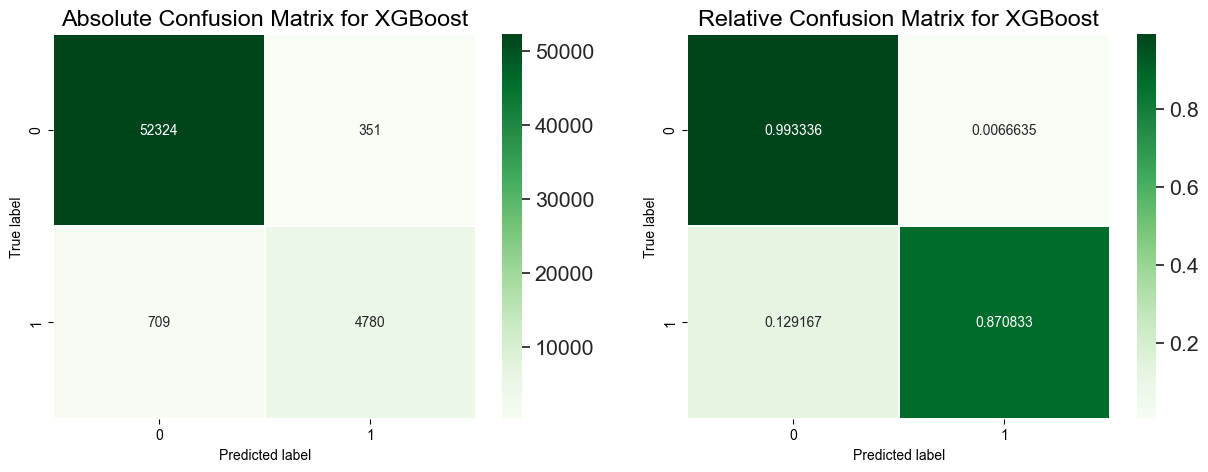

In [25]:
model = XGBoost_classification_tunned(best_hyperparams)

In [26]:

def while_XGBoost_classification_tunned(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best_results = (0,"",None,None, None)
    i = 0
    print(f"\r{i}", end="")
    for i in range(cycles):
        print(f"\r{i}", end="", flush=True)
        tmp_f1 = 0
        tmp_str = ""
        #Split on train and test
        X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
        for F, N in zip(
                [ features], # statistics_features, time_features, distribution_features, frequency_features, behavior_features, 
                [ "All"], # "Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based", 
        ):
                X_train = X_train_a[F]
                X_test = X_test_a[F] 
                model = XGBClassifier(
                        n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), 
                        # gamma = best_hyperparams['gamma'],
                        # reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                        # colsample_bytree=int(best_hyperparams['colsample_bytree']),
                        # subsample=int(best_hyperparams['subsample']),
                        # eta=best_hyperparams['eta'],
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
                precision = precision_score(y_test, y_pred)  * 100
                recall = recall_score(y_test, y_pred)  * 100
                F1 = f1_score(y_test, y_pred)  * 100
                if N == "All":
                    tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\hline"
                    tmp_str += "\n"
                    tmp_f1 = F1
                elif N in ["Statistical-based", "Distribution-based", "Behavior-based"]:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
                else:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & \\rowcolor{LigthGray} " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
        if best_results[0] < tmp_f1:
            matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
            best_results = (tmp_f1, tmp_str, matrix, percentage_matrix, model)
    print("")
    print("")
    print("")
    print(best_results[0])
    print(best_results[1])
    plot_confusion_matrix(best_results[2], best_results[3], model="XGBoost")
    return best_results[4]

24


92.4437752893573
\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}98.62 & 95.60 & 89.49 & 92.44 \\
\hline



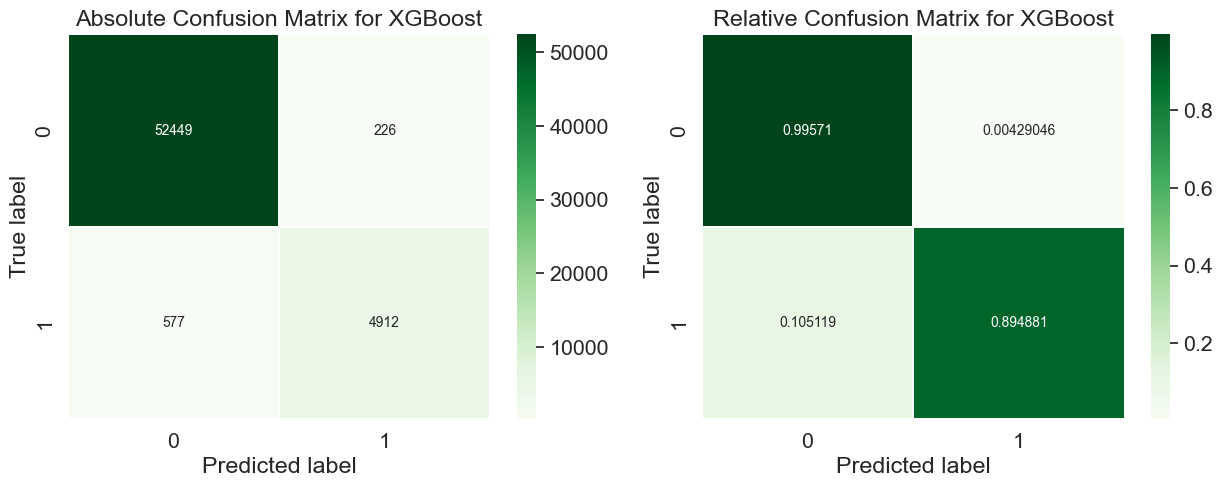

In [27]:
best_model = while_XGBoost_classification_tunned(best_hyperparams, cycles=25)

# Validation

\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}98.64 & 96.17 & 89.35 & 92.64 \\
\hline



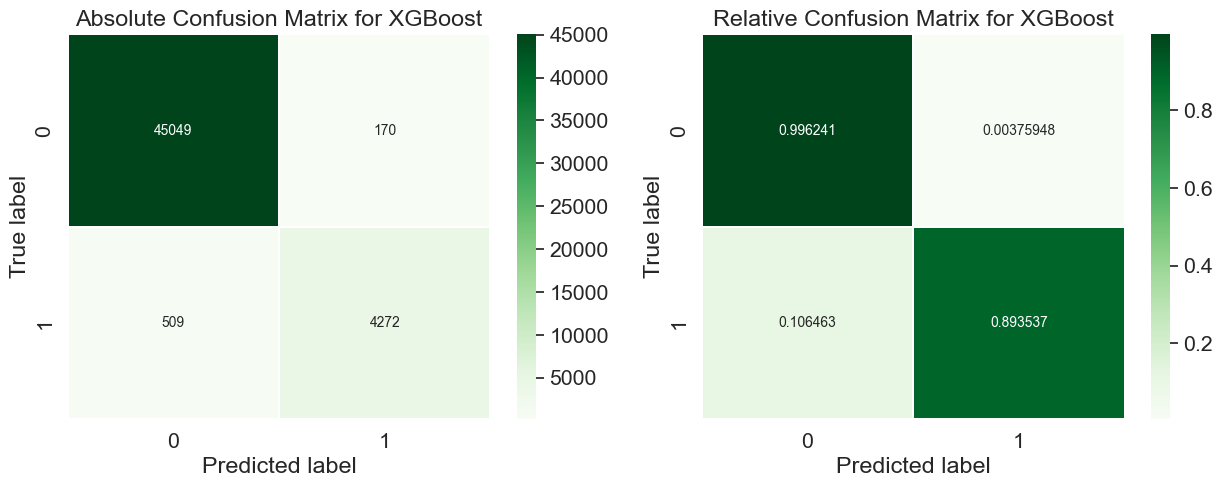

In [28]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
    

y_pred = best_model.predict(X_validation)
accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
precision = precision_score(y_validation, y_pred)  * 100
recall = recall_score(y_validation, y_pred)  * 100
F1 = f1_score(y_validation, y_pred)  * 100
                
tmp_str = ""
tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
tmp_str += "\n"
tmp_str += "\hline"
tmp_str += "\n"
print(tmp_str)

matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

# 94.75 & 95.71 & 96.08 & 95.90

# Feature importance

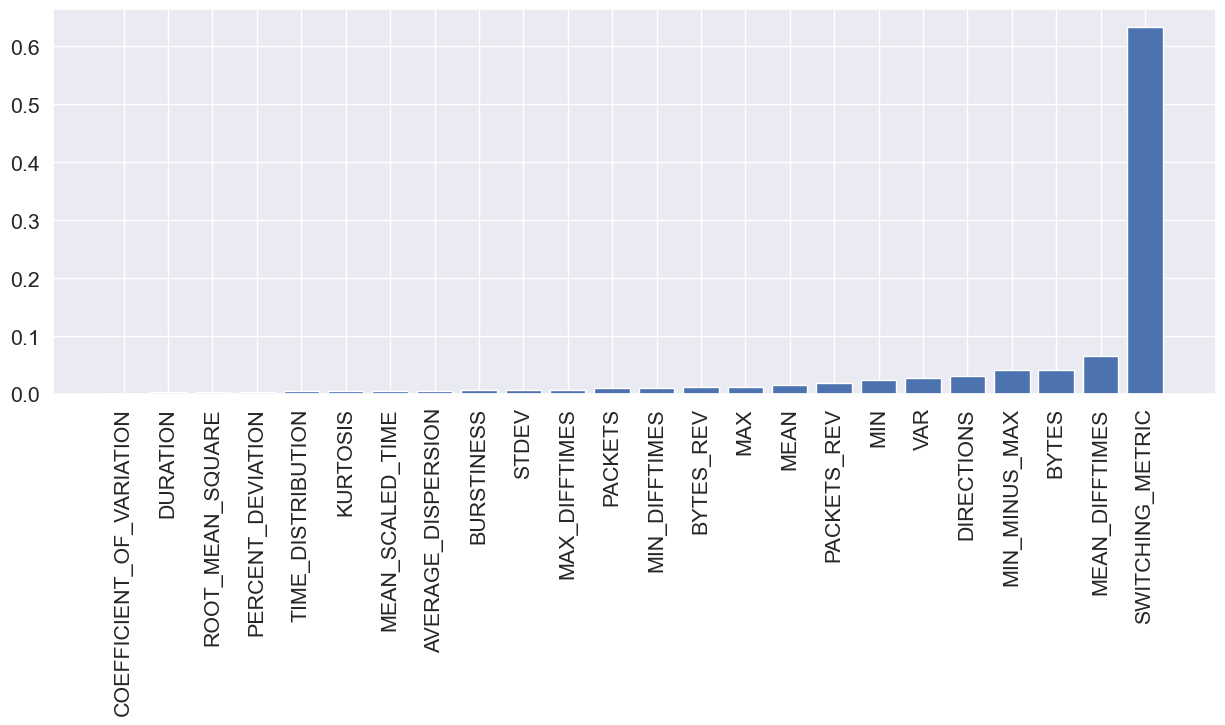

In [29]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()

In [30]:
feat_importances.to_dict()

{'COEFFICIENT_OF_VARIATION': 0.0,
 'DURATION': 0.003787777852267027,
 'ROOT_MEAN_SQUARE': 0.004205149598419666,
 'PERCENT_DEVIATION': 0.004400812089443207,
 'TIME_DISTRIBUTION': 0.004567655269056559,
 'KURTOSIS': 0.004621830768883228,
 'MEAN_SCALED_TIME': 0.00522591220214963,
 'AVERAGE_DISPERSION': 0.005464105401188135,
 'BURSTINESS': 0.006840137764811516,
 'STDEV': 0.007210190407931805,
 'MAX_DIFFTIMES': 0.0074457405135035515,
 'PACKETS': 0.009900226257741451,
 'MIN_DIFFTIMES': 0.010643740184605122,
 'BYTES_REV': 0.012691600248217583,
 'MAX': 0.012898766435682774,
 'MEAN': 0.01504917535930872,
 'PACKETS_REV': 0.019067345187067986,
 'MIN': 0.0247816052287817,
 'VAR': 0.028312193229794502,
 'DIRECTIONS': 0.031558942049741745,
 'MIN_MINUS_MAX': 0.04101340472698212,
 'BYTES': 0.041991520673036575,
 'MEAN_DIFFTIMES': 0.06605440378189087,
 'SWITCHING_METRIC': 0.6322677135467529}